# Part 2: Time Series Forecast with ARIMA (2 days) 📈

Welcome to the second part of your journey towards mastering the art of forecasting with ARIMA models. We will demystify ARIMA models, beginning with its foundational principles - autoregression, differencing, moving average. Using the same dataset as in Part 1, you will fit different models and assess their quality in order to compare them. You will also learn the different way of performing train/test splits and cross-validation in the context of time series!

In this notebook, we will cover the following concepts:
- Train / Test splitting for time series
- Naive forecasting models
- ARIMA and SARIMA models
- Cross-Validation for time series

**Objectives**
- Get to use few prediction models
- Understand Cross-Validation in the context of Time Series

**Ressources**

AR, MA, ARIMA :

- https://www.youtube.com/watch?v=Mc6sBAUdDP4&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=zNLG8tsA_Go&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=dXND1OEBABI&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=7

ACF & PACF :

- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Métriques :

- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

Cross-validation :

- https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
- https://robjhyndman.com/hyndsight/tscv/

Forecasting: Principles and Practice livre (Rob Hyndman) :

- https://otexts.com/fpp2/
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://otexts.com/fpp2/transformations.html
- https://otexts.com/fpp2/seasonal-arima.html

Documentation de Pmdarima:

- http://alkaline-ml.com/pmdarima/


**Required librairies**
- [ ] numpy
- [ ] pandas
- [ ] matplotlib
- [ ] seaborn
- [ ] pmdarima
- [ ] sktime

In [85]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import sktime as sk

# A bit of theory, again 😁

The ARMA (AutoRegressive Moving Average) model is suitable for predicting any time series whose value $Y$ at time $t$ can be explained by previous values and previous perturbations (noise).

Before specifying what a dataset is according to the ARIMA model, let's specify a dataset according to the conditions :  

- **Autoregressive**: the model predicts the variable $Y$ at time $t$, denoted $Y_t$, from previous values of $Y$ according to a linear regression model, i.e. $Y_{t-1}, Y_{t-2}, ..., Y_0$. Let $p$ denote the number of components used to predict $Y_t$, with

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, with $\varepsilon_t$ a perturbation, and c a constant.

- **Moving average**: a model where the data are the result of the moving average of order $q$. The value $Y_t$ can be expressed using the perturbation at time $t$ and its previous values:

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, with $\mu$ a constant.

Any ARMA model is the combination of the *AR* and *MA* conditions, i.e. it is autoregressive and its noise follows a moving average. Let :

> $Y_t = c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

or :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ with $\varepsilon_t$ the error of the autoregressive model at time $t$.

The model is optimized using the least-squares method.

An ARMA model is suitable for stationary data sets, i.e. with a fixed mean and standard deviation over time. Such data are rarely observed. Many time series datasets show trends in the mean or seasonal patterns. To do this, the problem must first be stationarized. As we saw before, this can be done by differencing the data, apply a model, and then performing the reverse operation: **integration**. An **ARIMA** model is said to be :

- **integrated**: when the data set can be corrected by running the model on $Y'_t = Y_t - Y_{t-1}$ for a correction of order 1 (d=1), or $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ for a correction of order 2 (d=2), etc...  We note $d$ the order of *correction by integration* to suppress polynomial tendencies of order $d$, with:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


ARIMA models are often denoted: ARIMA(p, d, q), or **ARIMA(2, 1, 1)** means :
- an autoregressive model of order 2,
- on data integrated 1 times,
- with a moving average of order 1.

# 1. Train / Test Splitting

Because the temporal order is important in time series, we cannot perform a random train/test split. Rather, we can use the most recent data (e.g. the last year) as the test set!

**TODO**
- Explain why train/test splitting can be a challenge for time series
- Write a function to split the dataset into a train and test set
- Use the function to split the airline passengers dataset, keeping the last twelve months as a test set
- Plot the train and test set in different colors

In [86]:
from sktime.datasets import load_airline

# Load dataset
airline = load_airline()

# Clean & Adjust the data
airline = airline.dropna()
airline_adj = airline / airline.index.days_in_month

In [87]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    
    
    # Split

    train = data[data.index < split_date]
    test = data[data.index >= split_date]

    

    return train, test

Train set: (107,)
Test set: (37,)
Split date: 1957-12


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

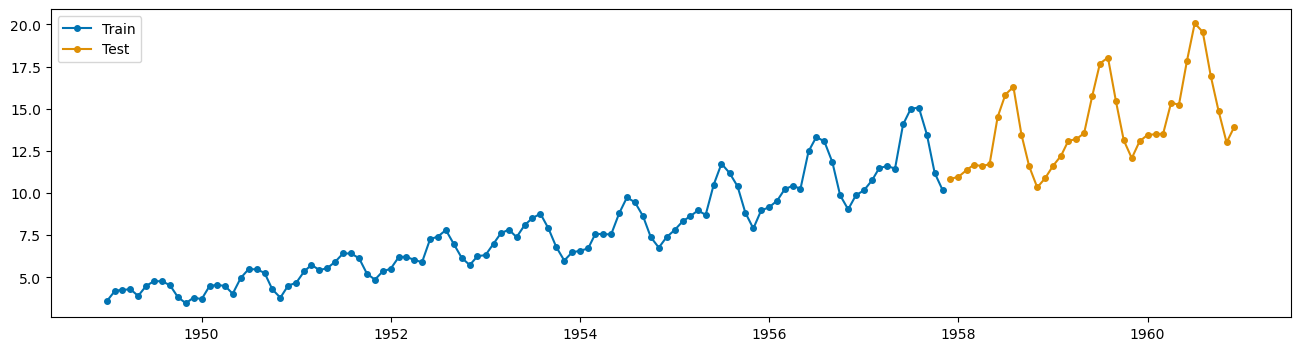

In [88]:
from sktime.utils.plotting import plot_series

# Hold back the last three years as a TEST set
split_date = airline_adj.index.max() - 3 * 12

train, test = ts_train_test_split(airline_adj, split_date)

# --- Check train and test sizes ---
print("Train set:", train.shape)
print("Test set:", test.shape)
print("Split date:", split_date)

# --- Plot the series ---
plot_series(train, test, labels=["Train", "Test"])
    





# 2. Naive Forecast

We need a baseline (as always!) to know if our more complex models are any use! Given the strong seasonal component that was confirmed by the seasonal decomposition we made earlier, it may be a good idea to use a **seasonal naive** forecasting method. This model takes the value from the same period in the previous season (in this case the same month last year). This is part of the Carry-Forward-Previous-Values' family of **naive** forecasting methods. In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words, we have yearly data so we just take the value from the same month last year.

In [89]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality

# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

### 2.1 Fit a Naive Forecaster

**TODO**
- Fit a Naive and Seasonal Naive forecaster to the train data, and show the predictions along with the test data.
- Plot the residuals using Seaborn's `displot()`, `regplot()` and `residplot()` functions.

In [90]:
# Your code for the Naive Forecaster
#strategies:
# auto =  last (robust against NaN values) forecast the last value in the training series when sp is 1. When sp is not 1, last value of each season in the last window will be forecasted for each season.
#means =  (robust against NaN values)forecast the mean of last window of training series when sp is 1. When sp is not 1, mean of all values in a season from last window will be forecasted for each season.
#drift= not robust against Naan values- forecast by fitting a line between the first and last point of the window and extrapolating it into the future.
model = NaiveForecaster(strategy = 'last')


In [91]:
#Train 
model.fit(train)

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)


NaiveForecaster()

In [92]:
#Predict
y_pred = model.predict(fh)
y_pred

1957-12    10.166667
1958-01    10.166667
1958-02    10.166667
1958-03    10.166667
1958-04    10.166667
1958-05    10.166667
1958-06    10.166667
1958-07    10.166667
1958-08    10.166667
1958-09    10.166667
1958-10    10.166667
1958-11    10.166667
1958-12    10.166667
1959-01    10.166667
1959-02    10.166667
1959-03    10.166667
1959-04    10.166667
1959-05    10.166667
1959-06    10.166667
1959-07    10.166667
1959-08    10.166667
1959-09    10.166667
1959-10    10.166667
1959-11    10.166667
1959-12    10.166667
1960-01    10.166667
1960-02    10.166667
1960-03    10.166667
1960-04    10.166667
1960-05    10.166667
1960-06    10.166667
1960-07    10.166667
1960-08    10.166667
1960-09    10.166667
1960-10    10.166667
1960-11    10.166667
1960-12    10.166667
Freq: M, dtype: float64

In [93]:
# Your code for the Seasonal Naive Forecaster
model2 = NaiveForecaster(strategy = 'last', sp = 12)

In [94]:
# Model2 train
model2.fit(train)

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)


NaiveForecaster(sp=12)

In [95]:
#Model2 predict 
y_pred2 = model2.predict(fh)

Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

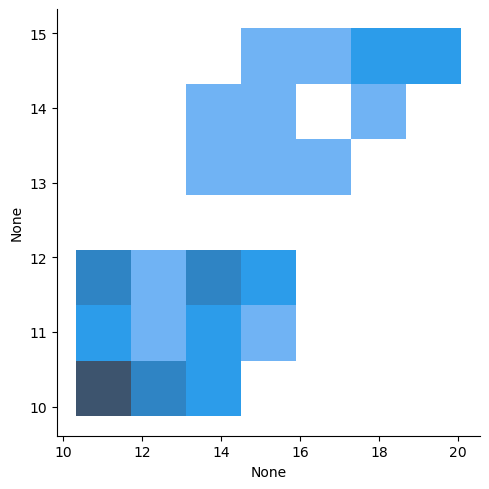

In [96]:
# Plot the residuals using Seaborn's `displot()`, `regplot()` and `residplot()` functions.
sns.displot( x=test, y = y_pred2)
plt.show()

<Axes: >

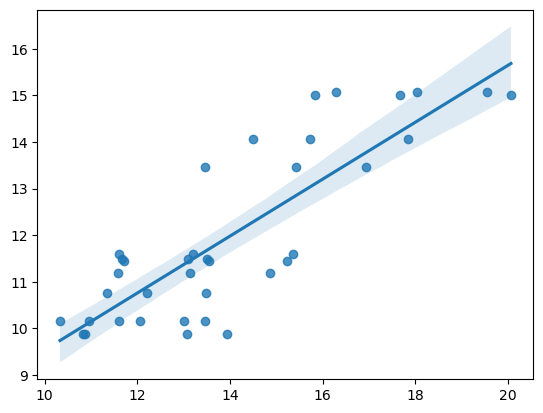

In [97]:
#`regplot()
sns.regplot(x = test, y = y_pred2)

<Axes: >

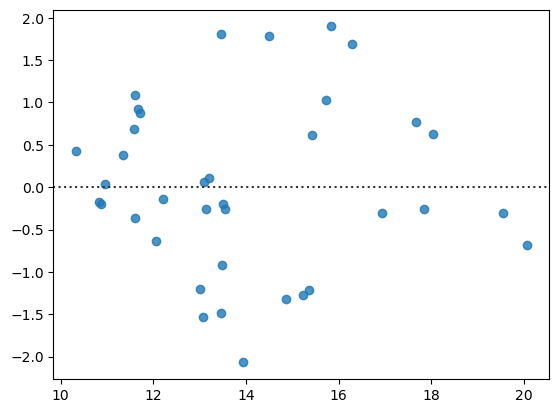

In [98]:
#residplot()
sns.residplot(x = test, y = y_pred2)


### 2.2 Error Metrics

You've probably already worked with the Mean Squared Error (MSE). Let's have a look at different metrics.

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

**TODO**
- Write a function to compute the MAPE
- Calculate the in-sample RMSE and MAPE for the last twelve months

In [99]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    e = y_pred-y_true
    p = 100*e/y_true
    MAPE = np.mean(p)
    
    return

In [100]:
# Your code calculating the RMSE and MAPE for the Naive and Seasonal Naive models
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
#Naive Model
RMSE_naive = root_mean_squared_error(test, y_pred)
MAPE_naive = mean_absolute_percentage_error(test, y_pred)
print('RMSE naive Model = ', RMSE_naive)
print ('MAPE naive Model = ', MAPE_naive)


RMSE naive Model =  4.546867377984849
MAPE naive Model =  0.2507559836819589


In [101]:
RMSE_naive_seasonnal = root_mean_squared_error(test, y_pred2)
MAPE_naive_seasonnal = mean_absolute_percentage_error(test, y_pred2)
print('RMSE Seasonal naive Model = ', RMSE_naive)
print ('MAPE Seasonnal naive Model = ', MAPE_naive)

RMSE Seasonal naive Model =  4.546867377984849
MAPE Seasonnal naive Model =  0.2507559836819589


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

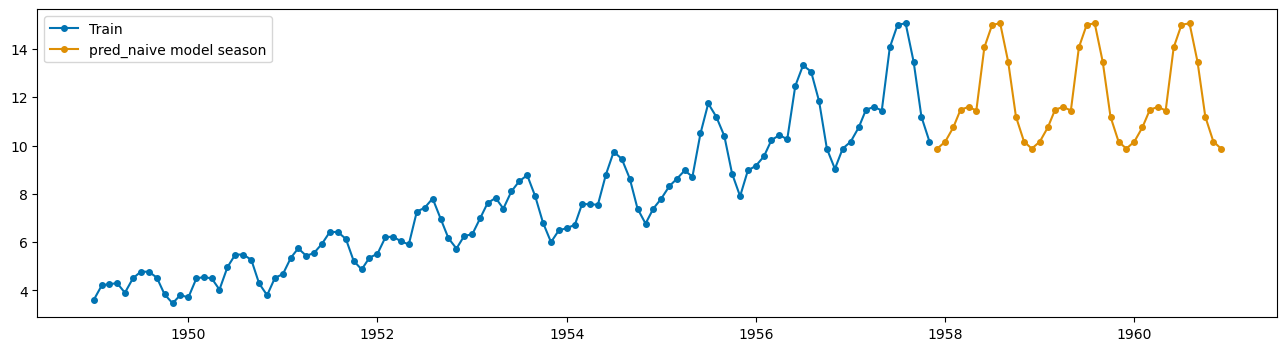

In [102]:

# --- Plot the series ---
plot_series(train, y_pred2, labels=["Train", "pred_naive model season"])

# 3. ARIMA Forecast


Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over the options available in the core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember is that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formula for automatically selecting a good ARIMA forecasting model.

Even though modern applications tend to opt for the automatic approach for selecting the ARIMA parameters, we will have a go a trying and comparing how we perform with manual selection. As we discussed above, to train an ARIMA($p$,$d$,$q$) model we need to specify three parameters: $p$ (*AR*), $d$ (*I*) and $q$ (*MA*):
- To determine $p$, we look at the *direct* correlations, i.e. the *PACF*, and search for the lag $i$ such that $PACF_i \approx 0$
- To determine $q$, we look at the *full* correlations, i.e. the *ACF*, and search for the lag $i$ such that $ACF_i \approx 0$

Sometimes, we cannot apply directly these guidelines, and we must rely on a more detailed analysis or a grid search to determine the best $p,q$ for the problem at hand.

### Load the dataset & transform it

ARIMA models can take into account an increasing mean over time, but not the variance. Thus, a log transformation is enough for our purposes!

In [103]:
# Reload dataset from pmdarima
from pmdarima.datasets import load_airpassengers
from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

# Load dataset
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

# There's no DateTimeIndex from the bundled dataset. So let's add one.
airline.index = pd.date_range(START_DATE, periods=len(airline), freq='MS')

# Clean & Adjust data
airline_adj = airline / airline.index.days_in_month

# Train / Test split
train, test = ts_train_test_split(airline_adj, '1960-01-01')

# Apply log transformation
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

### 3.1 Estimate $p$, $d$ and $q$

**TODO**
- Based on the analysis done on the previous notebook, what would be a plausible value for $d$ ?
- Plot the ACF and PACF and determine some plausible values for $p$ and $q$.
- Fit the ARIMA model and show the diagnostics using the `plot_diagnostics()` of pmdarima. Describe the different plots. How do you interpret these results ?

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) (Original Data)')

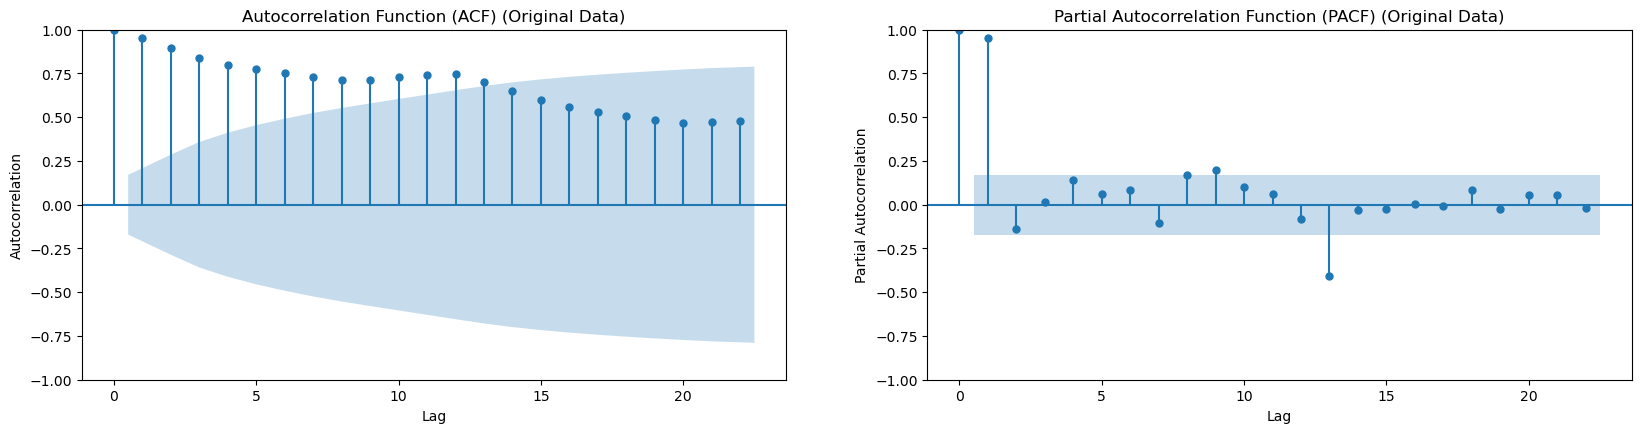

In [104]:
# The plausible value of d is 1 as the rolling mean is linear (it would have been 2 if the rolling mean were quadratic).
# Your code for the ACF & PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1)
plot_acf(train_log, ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF) (Original Data)")

# Plot PACF

ax1 = fig.add_subplot(2,2,2)
plot_pacf(train_log, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Partial Autocorrelation")
ax1.set_title("Partial Autocorrelation Function (PACF) (Original Data)")

In [105]:
# Your code for the ARIMA model
#step 1:
    # if d=1 you need to do a differentiation 
data_diff = train_log.diff()

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) (Original Data)')

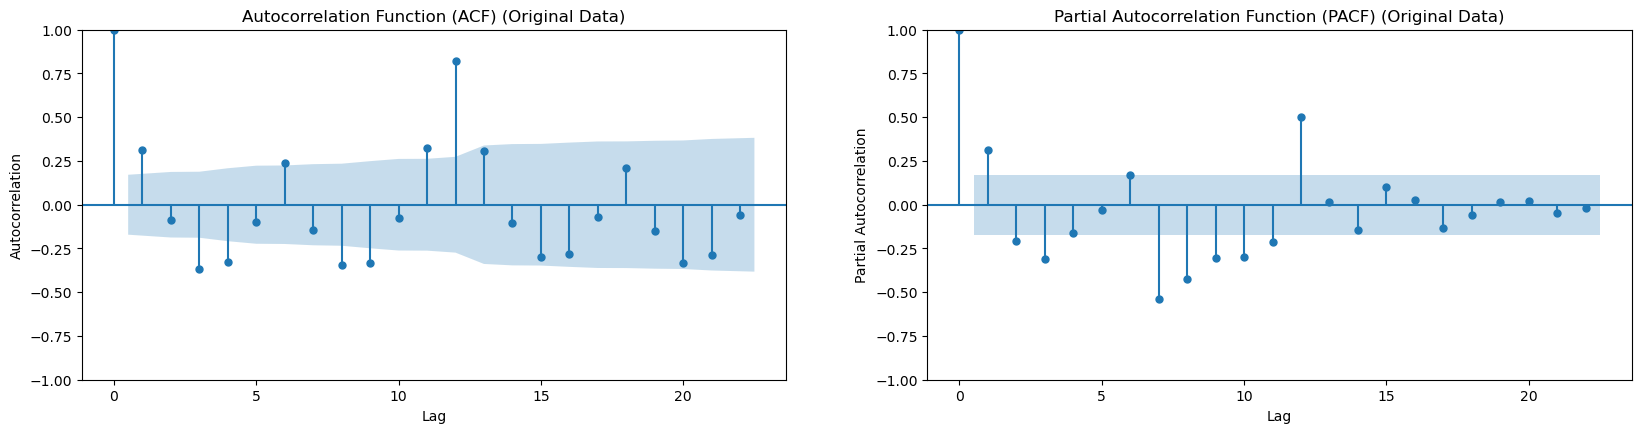

In [106]:
# Plot the ACF and PACF
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1)
plot_acf((data_diff.dropna()), ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF) (Original Data)")

# Plot PACF

ax1 = fig.add_subplot(2,2,2)
plot_pacf(data_diff.dropna(), ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Partial Autocorrelation")
ax1.set_title("Partial Autocorrelation Function (PACF) (Original Data)")

In [107]:
# p = i when PACF is almost = 0
# q = i when ACF is almost = 0

p = 12
d = 1
q = 12

#you can give list of lags outside the confident interval 
import pmdarima as pm
from pmdarima.model_selection import train_test_split
ARIMA_model = ARIMA(order =(p,d,q))

In [108]:
#train model 
ARIMA_model.fit(train_log)

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Lik

,order,"(12, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


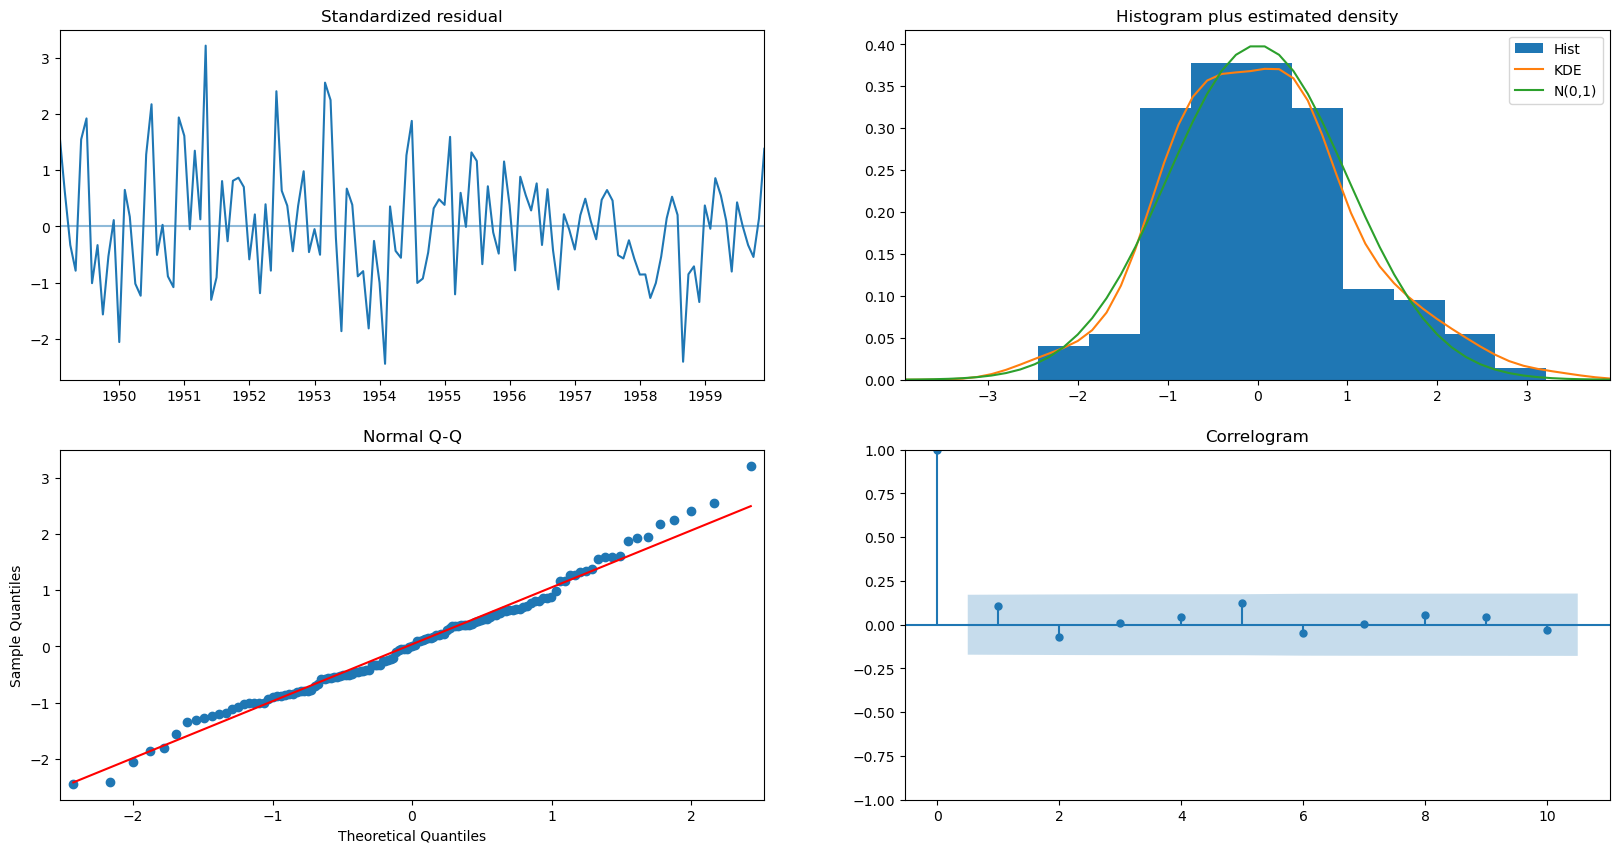

In [109]:
ARIMA_model.plot_diagnostics(figsize= (20,10))
plt.show()

**TODO**
- Make a figure showing the train set, the test set, the predictions from ARIMA and the confidence intervals
- Make a second figure showing the predictions for the next 100 periods
- Calculate the RMSE and the MAPE on the test set

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

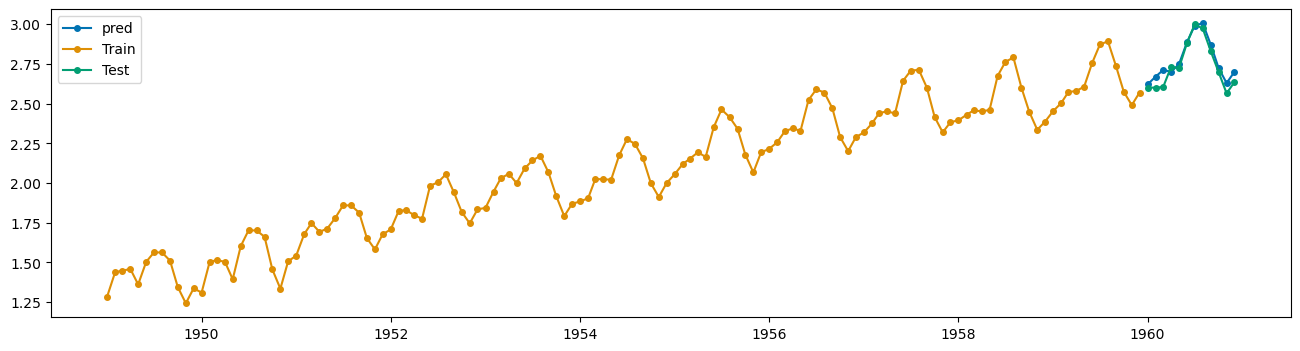

In [110]:
# Your code showing train, test, predictions and confidence interval

y_pred_arima_model = ARIMA_model.predict(12)


# --- Plot the series ---
plot_series(y_pred_arima_model, train_log, test_log, labels=["pred","Train", "Test"])


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


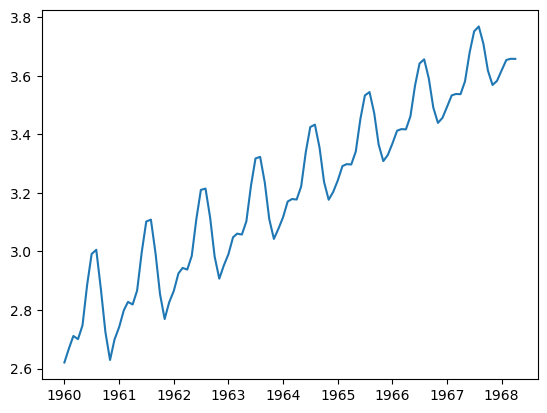

In [111]:
# Your code for showing the predictions for 100 periods
y_pred_arima_model100 = ARIMA_model.predict(100)

plt.plot(y_pred_arima_model100)

In [112]:
from sklearn.metrics import mean_squared_error

# Your code calculating the RMSE and MAPE

RMSE_ARIMA = root_mean_squared_error(test_log, y_pred_arima_model)
MAPE_ARIMA = mean_absolute_percentage_error(test_log, y_pred_arima_model)
print('RMSE Arima Model = ', RMSE_ARIMA)
print ('MAPE Arima Model = ', MAPE_ARIMA)



RMSE Arima Model =  0.050187208368786075
MAPE Arima Model =  0.015478680017730513


In [113]:
#The RMSE decreased which indicates that the model's predictions are closer to the actual values = the model is performing better
#A lower  mean Absolute Percentage Error (MAPE) indicates a more accurate prediction.

**Conclusions**
- What are your conclusions ?
- What do you think about the error?

### 3.2 Seasonal ARIMA


As we have seen previously, ARMA models are well suited for stationary data. They may even works for data presenting seasonality, however seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

**Example** : Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of $p=12*12$ to comprehend seasonality of the problem!

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

The Seasonal ARIMA model, also known as SARIMA, is an extension of the basic ARIMA model that takes into account seasonality in the data. In a SARIMA model, we introduce additional seasonal components to the ARIMA model. The seasonal components mirror the ARIMA components but are applied to the seasonal patterns in the data. So, the SARIMA model has six additional parameters:

- Seasonal Autoregressive (SAR) component: This is similar to the AR component but for the seasonal patterns. It represents the relationship between the current value of the time series and its past values at the seasonal frequency.

- Seasonal Integrated (SI) component: This is similar to the I component but for the seasonal patterns. It involves differencing the time series at the seasonal frequency to achieve seasonality stationarity.

- Seasonal Moving Average (SMA) component: This is similar to the MA component but for the seasonal patterns. It models the relationship between the current value of the time series and past forecast errors at the seasonal frequency.

The seasonal frequency $s$ refers to the number of time periods that make up one seasonal cycle, and must also be provided to a SARIMA model. For example, if the time series exhibits a yearly seasonality, the seasonal frequency is 12 (assuming monthly data).

**TODO**
- Using a seasonal decomposition of the dataset, separate it into trend, seasonality and residual parts.
- Plot the moving mean and std of the trend and seasonal parts of the data.
- What can you conclude about stationarity of seasonal data? Can you then define $D$ and the seasonal frequency $s$ ?
- Does intra-seasonal data show specific seasonality ? What is $d$ (0, 1, or 2) ?
- Use the same procedure applied previously to a build a SARIMA model and evaluate its performance.

In [114]:
def moving_mean(x, n):
    return x.rolling(n).mean()

def moving_std(x, n):
    return x.rolling(n).std()

1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1959-08-01   NaN
1959-09-01   NaN
1959-10-01   NaN
1959-11-01   NaN
1959-12-01   NaN
Freq: MS, Name: trend, Length: 132, dtype: float64
1949-01-01   -0.105101
1949-02-01   -0.034492
1949-03-01    0.010329
1949-04-01    0.000197
1949-05-01   -0.029634
                ...   
1959-08-01    0.180321
1959-09-01    0.078999
1959-10-01   -0.094253
1959-11-01   -0.203259
1959-12-01   -0.119181
Freq: MS, Name: seasonal, Length: 132, dtype: float64
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1959-08-01   NaN
1959-09-01   NaN
1959-10-01   NaN
1959-11-01   NaN
1959-12-01   NaN
Freq: MS, Name: resid, Length: 132, dtype: float64


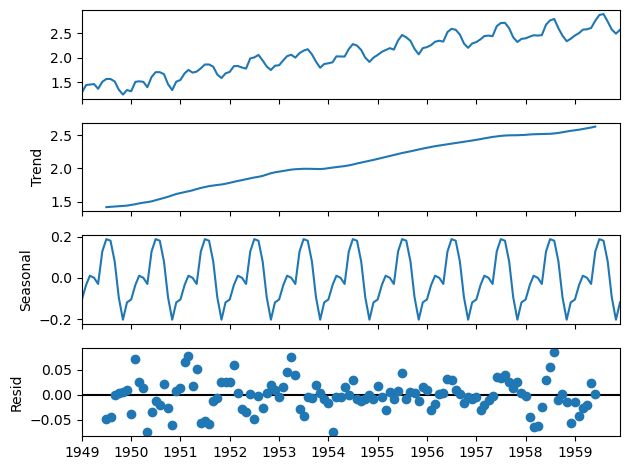

In [115]:
# Decompose the data into a trend and seasonal part
from statsmodels.tsa.seasonal import seasonal_decompose

arima_deco = seasonal_decompose(train_log, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)


print(arima_deco.trend)
print(arima_deco.seasonal)
print(arima_deco.resid)


arima_deco.plot()

plt.show()

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) (ARIMA_seasonal)')

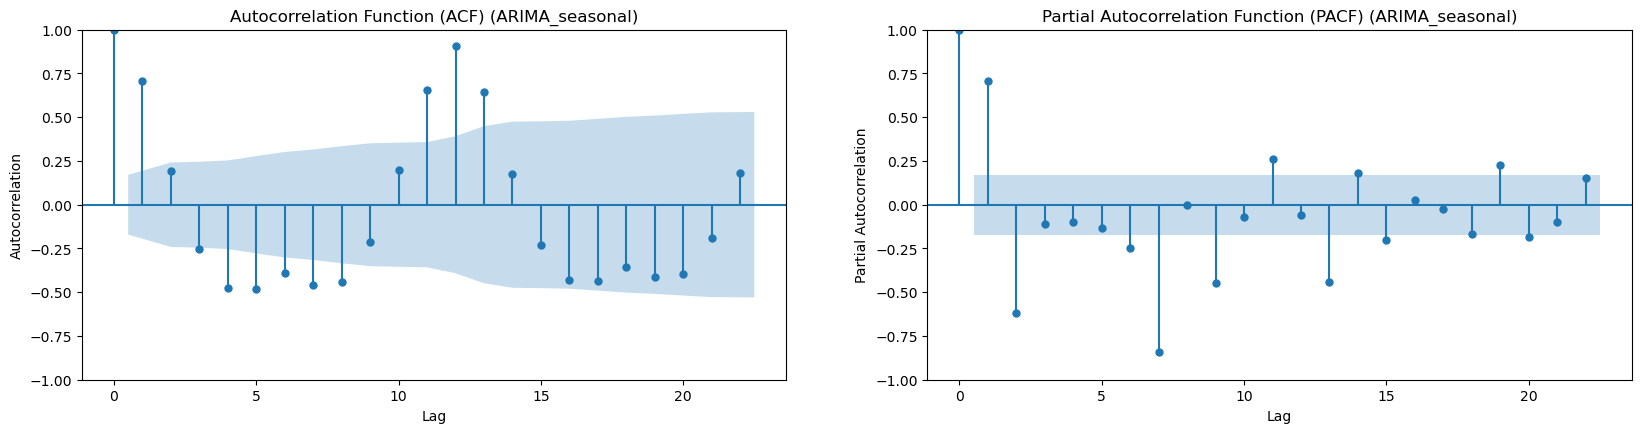

In [116]:
# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot the ACF and PACF
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1)
plot_acf(arima_deco.seasonal, ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF) (ARIMA_seasonal)")

# Plot PACF

ax1 = fig.add_subplot(2,2,2)
plot_pacf(arima_deco.seasonal, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Partial Autocorrelation")
ax1.set_title("Partial Autocorrelation Function (PACF) (ARIMA_seasonal)")



Text(0.5, 1.0, 'Trend part - Rolling STD')

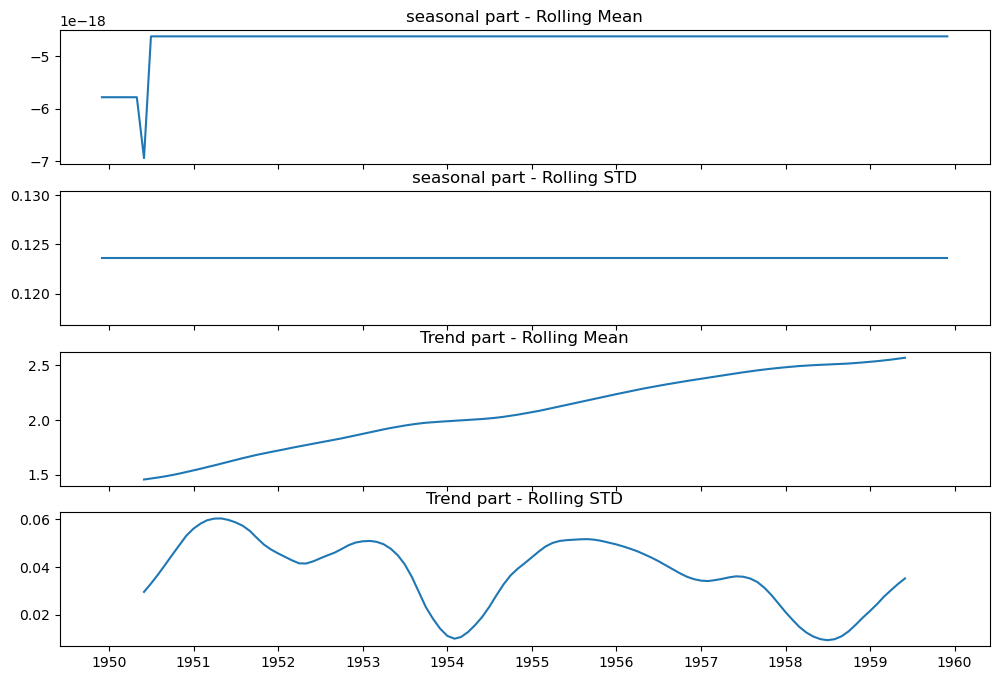

In [117]:
#Plot the moving mean and std of the trend and seasonal parts of the data. -- to know if the data are stationary.
# - "Passengers"
# - "Rolling mean"
# - "Rolling standard deviation"

# Plot results
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
#Seasonal
axes[0].plot(arima_deco.seasonal.rolling(window=12).mean())
axes[0].set_title('seasonal part - Rolling Mean')
axes[1].plot(arima_deco.seasonal.rolling(window = 12).std())
axes[1].set_title('seasonal part - Rolling STD')

#Trends
axes[2].plot(arima_deco.trend.rolling(window=12).mean())
axes[2].set_title('Trend part - Rolling Mean')
axes[3].plot(arima_deco.trend.rolling(window = 12).std())
axes[3].set_title('Trend part - Rolling STD')



In [118]:
# Calculate ADF et KPSS to know if dataset is stationary  
##For ADF model- model is stationary if p-value <= 0.05
#For KPSS model is stationary if p-value >0.05


In [119]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


In [120]:
adf_test(arima_deco.seasonal)

#p-value < = 0.05 so the model is stationary 

Results of Dickey-Fuller Test:
Test Statistic                -2.510637e+15
p-value                        0.000000e+00
#Lags Used                     1.100000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


In [121]:
kpss_test(arima_deco.seasonal)
#p-value > 0.05 so the model is stationary 

Results of KPSS Test:
Test Statistic           0.011899
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_7961/3717768510.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [122]:
#trend 
adf_test(arima_deco.trend.dropna())
#p-value> 0.05 so the model is not stationary- you need to differentiate the data

Results of Dickey-Fuller Test:
Test Statistic                  -1.626116
p-value                          0.469524
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [123]:
kpss_test(arima_deco.trend.dropna())
#the p-value < 0.05 so the model is not stationary - you need to differentiate the data.

Results of KPSS Test:
Test Statistic           1.798743
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_7961/3717768510.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [124]:
#we differentiate the data to make the model stationary
data_log_diff = arima_deco.trend.diff()



In [125]:
adf_test(data_log_diff.dropna())
#pvalue > 0.05 so the dataset is no stationary- you need another diff.

Results of Dickey-Fuller Test:
Test Statistic                  -2.166859
p-value                          0.218493
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [126]:
data_log_diff2 = data_log_diff.diff()

In [127]:
#We test data_log_diff2 for stationarity

adf_test(data_log_diff2.dropna())
#pvalues < 0.05 so the dataset is stationary. So d = 2

Results of Dickey-Fuller Test:
Test Statistic                  -4.504400
p-value                          0.000193
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) (ARIMA_Trend)')

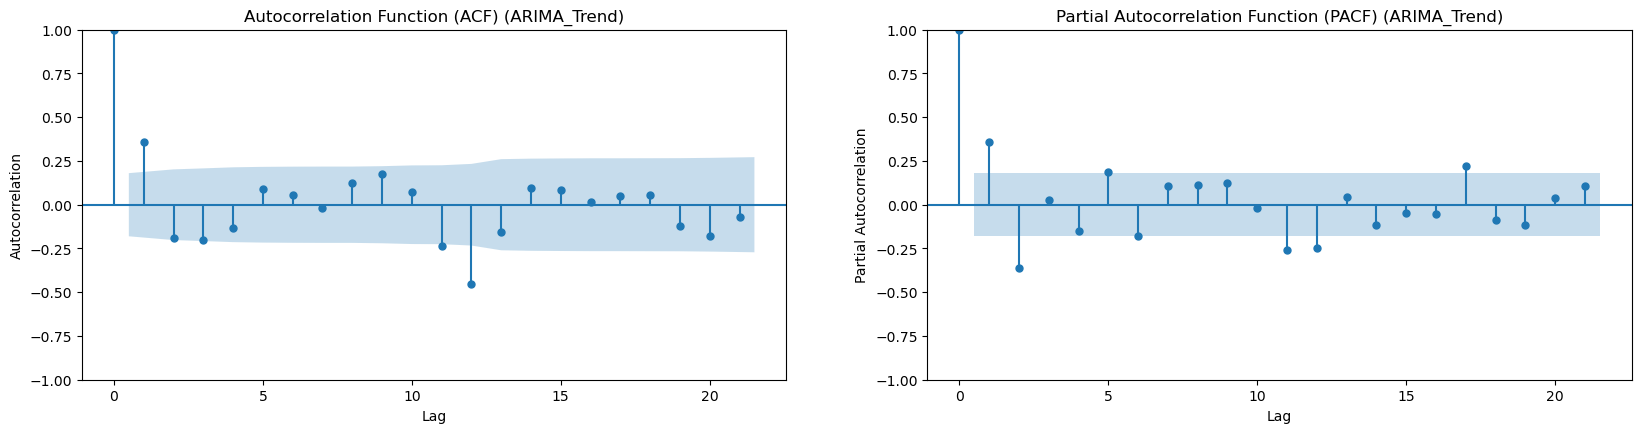

In [128]:
# we look for p and q so we plot ACF and PACF using the stationary dataset (data_log_diff2 dataset)

# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1)
plot_acf(data_log_diff2.dropna(), ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF) (ARIMA_Trend)")

# Plot PACF

ax1 = fig.add_subplot(2,2,2)
plot_pacf(data_log_diff2.dropna(), ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Partial Autocorrelation")
ax1.set_title("Partial Autocorrelation Function (PACF) (ARIMA_Trend)")

In [129]:
#check p and q

p = [1,2,11]
q = [1]

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) (ARIMA_Seasonal)')

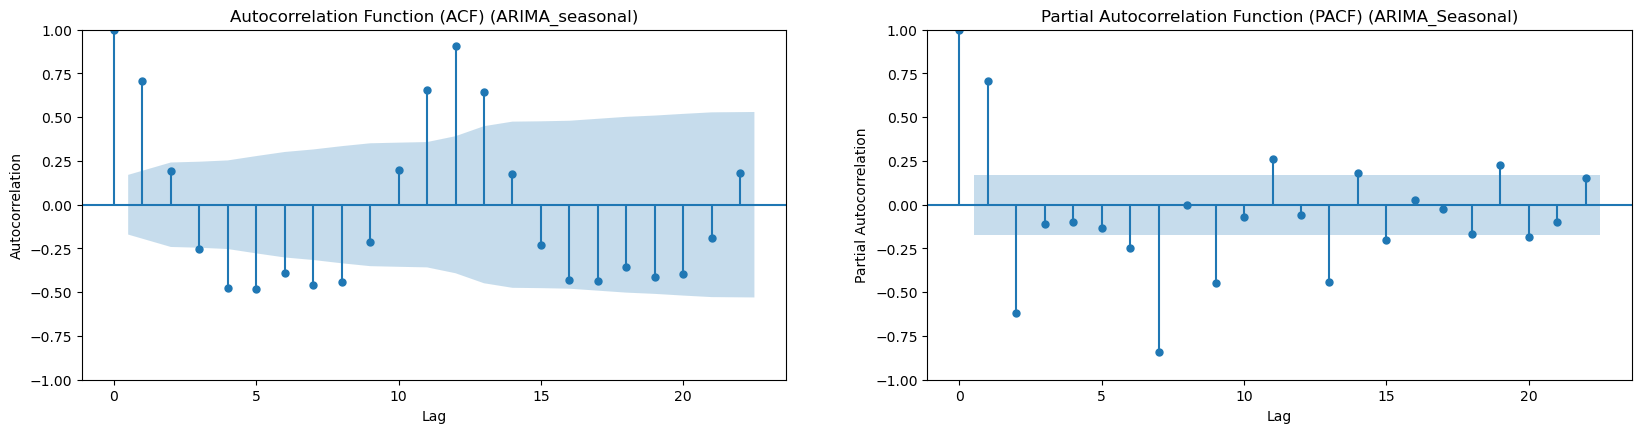

In [130]:
#We got p,q, d From the trend data. Now we weed to get P,Q,D from the seasonal dataset. 
#As our seasonal dataset is already stationary we do not need to differentiate. D = 0
#To find P and Q we plot the ACF and PACF

# Plot the ACF and PACF
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1)
plot_acf(arima_deco.seasonal.dropna(), ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF) (ARIMA_seasonal)")

# Plot PACF

ax1 = fig.add_subplot(2,2,2)
plot_pacf(arima_deco.seasonal.dropna(), ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Partial Autocorrelation")
ax1.set_title("Partial Autocorrelation Function (PACF) (ARIMA_Seasonal)")





In [131]:
#From the plot you get the lags for P and Q
D = 0
Q = 1
P = [1,2,7,9]
S = 12 #seasonnality 

In [132]:
# Fit the SARIMA model
sarima_model = ARIMA(order = (p,d,q), seasonal_order = (P,D,Q,S))


In [133]:
sarima_model.fit(train_log)

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Lik

,order,"([1, 2, ...], ...)"
,seasonal_order,"([1, 2, ...], ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_7961/2766944889.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


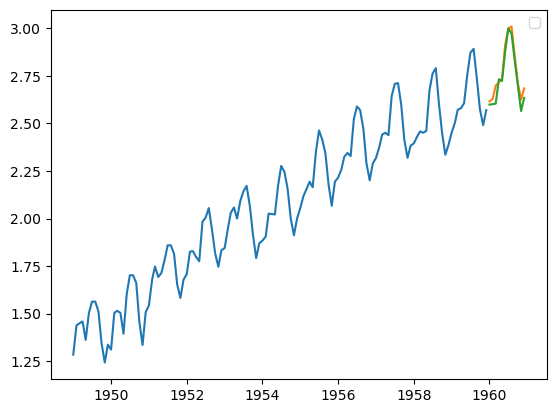

In [145]:
# Show train, test, predictions and confidence interval
y_sarima_pred = sarima_model.predict(12) 

plt.plot(train_log)
plt.plot(y_sarima_pred)
plt.plot(test_log)
plt.legend()



In [147]:
# Calculate the RMSE and the MAPE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

RMSE_Sarima = root_mean_squared_error(test_log, y_sarima_pred)
MAPE_Sarima = mean_absolute_percentage_error(test_log, y_sarima_pred)
print('RMSE Seasonal Model = ', RMSE_Sarima)
print ('MAPE Seasonal Model = ', MAPE_Sarima)




RMSE Seasonal Model =  0.040528692761334306
MAPE Seasonal Model =  0.011964919879074304


**Conclusions**
- What are your conclusions with respect to the previous ARIMA model ?

### 3.3 Auto-Arima  🎉

Auto ARIMA is an automated time series forecasting method that automatically selects the best combination of ARIMA model parameters ($p$, $d$, $q$) based on the data's characteristics. It uses algorithms to iteratively search and evaluate different models to find the most suitable one, saving users from manually tuning the parameters. Auto ARIMA is a powerful tool for efficiently forecasting time series data, especially when dealing with large datasets or when users have limited knowledge of time series modeling.

**TODO**
- Fit an `auto_arima` model and plot the diagnostics.
- How does it compare to the best model you found previously ?

In [153]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

auto_arima_model = auto_arima(train_log,start_p=1, start_q=1,
    max_p=5, max_q=5,
    m=12,                     # 12 for monthly seasonality
    start_P=0, seasonal=True, # Set seasonal=False for non-seasonal data
    d=None, D=None,           # Let auto_arima find these automatically
    trace=True,               # Print model search progress
    error_action='ignore',    # Ignore non-working models
    suppress_warnings=True,   # Avoid unnecessary warnings
    stepwise=True             # Use a stepwise search (faster)
)

print(auto_arima_model.summary())

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-453.158, Time=2.67 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-320.015, Time=0.03 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-441.984, Time=0.64 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-387.929, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-135.423, Time=0.02 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-422.618, Time=0.26 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-451.374, Time=1.09 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-451.352, Time=2.06 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-448.716, Time=1.01 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-449.188, Time=2.14 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-448.908, Time=0.73 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-452.411, Time=1.18 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-451.671, Time=1.36 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-330.728, Time=0.62 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-422.724, Time=0.81 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-454.083, Time=0.68 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-423.787, Time=0.13 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-452.021, Time=1.06 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=-452.209, Time=1.92 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-449.571, Time=0.96 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,2)[12] intercept   : AIC=-450.518, Time=2.13 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,1,1)[12] intercept   : AIC=-452.383, Time=1.38 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,1,1)[12] intercept   : AIC=-450.415, Time=1.12 sec


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12]             : AIC=-446.749, Time=0.65 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 25.226 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 232.042
Date:                              Tue, 28 Oct 2025   AIC                           -454.083
Time:                                      12:49:07   BIC                           -440.146
Sample:                                  01-01-1949   HQIC                          -448.423
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

**Conclusions**
- How does `auto_arima` perform with respect to your previous models ? Can you explain why ?

# 4. Cross-Validation

As you know, cross-validation is a crucial technique in the context of machine learning, designed to assess the predictive performance of these models and mitigate potential pitfalls associated with using limited data. Unlike traditional cross-validation used in other machine learning applications, time series cross-validation takes into account the temporal order of the data, ensuring that does not have any information from the future that it would not otherwise have at the time of making a forecast. 
By dividing the time series data into multiple subsets and iteratively validating the model's performance against unseen data, cross-validation provides valuable insights into how well the ARIMA model generalizes to different time periods. This rigorous evaluation will allow you to fine-tune model hyperparameters (such as ARIMA's parameters), assess forecast accuracy, and build more robust and reliable time series forecasting models.

In the classicial time series literature, time series cross validation is called a **Rolling Forecasting Horizon**. This is explained in details [here](https://robjhyndman.com/hyndsight/tscv/)

**TODO**
- Split the train data into a train and validation sets

In [178]:
# I've written a function to help with the cv of the baseline model
# THIS FUNCTION IS LOCATED IN THE ./forecast DIRECTORY, ALONG WITH THE NOTEBOOK
from forecast.model_selection import time_series_cv

# It requires the data to be split into train and validation
train_cross, val_cross = ts_train_test_split(train_log, '1956-09-01')


# Print the sizes to see if it's all good
print('train cross size', len(train_cross))
print('val cross size', len(val_cross))


train cross size 92
val cross size 40


### 4.1 Cross-Validation with Naive model

**TODO**
- Perform a cross-validation with the Seasonal Naive model you built previously

In [179]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality

# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

In [195]:
# Define the model

naive_model= NaiveForecaster(strategy = 'last')


# Call time_series_cv

cv_scores=time_series_cv(naive_model, error_func = root_mean_squared_error, train = train_cross, val = val_cross, horizons = [12])
# Show results


/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_w

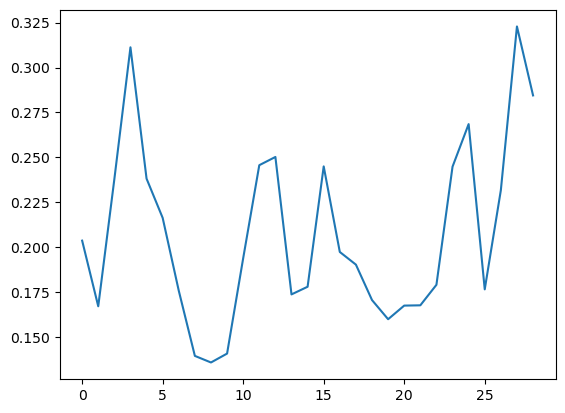

In [196]:
plt.plot(cv_scores)

### 4.2 Cross-Validation with ARIMA

**TODO**
- Perform a cross-validation with your best ARIMA model. 
- Try different step values in the RollingForecastCV. What's the difference ?
- In each case, what's the size of the the data the model is trained on ?
- How many splits did we get ?

In [210]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

# Manually create the arima model
arima_model = ARIMA(order = (p,d,q), seasonal_order = (P,D,Q,S))


# Create a RollingForecastCV instance
forescastcv = RollingForecastCV(h = 12, step = 1)

# Call cross_val_score
cv_scoresarimamodel = cross_val_score(
    arima_model,
    y=train_log,
    scoring= 'mean_squared_error',
    cv=forescastcv
)

/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/melanie.benyadi@Digital-Grenoble.local/anaconda3/envs/ML6bis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters foun

In [211]:
cv_scoresarimamodel

array([0.00214379, 0.00117219, 0.00156847, 0.00551571, 0.00378852,
       0.00311602, 0.0049082 , 0.00755182, 0.01992859, 0.01377979,
       0.00964249, 0.00799696, 0.00938309, 0.00639563, 0.00444525,
       0.0023152 , 0.00350551, 0.00437091, 0.01534647, 0.00935833,
       0.00680196, 0.00183664, 0.00184304, 0.00195044, 0.00259538,
       0.00356033, 0.00521578, 0.00504226, 0.00549193, 0.00258148,
       0.00205844, 0.00733902, 0.00811614, 0.00716169, 0.00094828,
       0.00052005, 0.0002694 , 0.00036449, 0.00053466, 0.00098934,
       0.00059912, 0.00077085, 0.00098902, 0.00145615, 0.00238839,
       0.00241004, 0.00384221, 0.00307309, 0.0033844 , 0.00180458,
       0.0005128 , 0.00042976, 0.0006704 , 0.0013697 , 0.00152511,
       0.00341505, 0.00495953, 0.00809115, 0.01165971, 0.00913821,
       0.01182094, 0.01012501, 0.01103664, 0.01355366, 0.00629033,
       0.00320331, 0.00178026, 0.00352262, 0.00421799, 0.00673444,
       0.0022876 , 0.00214052, 0.00375941, 0.00259338, 0.00329

# 5. The Final Forecast

**TODO**
- Following the same methodology as above, produce your final forecast with your best model!
- Plot the predictions of the **Naive**, **Seasonal Naive**, and your best **SARIMA** model along with the test data, and compare they performances!

In [ ]:
# Your code here
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

airline = load_airline().dropna()
airline = airline / airline.index.days_in_month
train, test = ts_train_test_split(airline, '1960-01-01')
train_log = np.log(train).dropna()

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality


# Define models


# Fit models


# Create predictions


# Plot predictions


# Bonus

### B1. Write a class with the following methods:
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Have some time left ?** 
* Add a method `get_cv` Which performs cross validation
* To further automatize the process, add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit such as a log transformation.

In [ ]:
# Write your class here




### B2. Test this method on all the other [11 datasets] of pmdarima

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [ ]:
dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']

def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pm.datasets, 'load_'+ds_name)(as_series=True).dropna()
    
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    
    return ds.dropna()

### B3. Want some more ?

Choose your poison: https://data.world/datasets/time-series